# Setup
To use ATOCA (Algorithm to Treat Order ContAmination), the jwst dms needs to be properly installed.
Also, the simulated data set needs to be downloaded. This notebook assumes that every reduction steps required before the 1d extraction have been perform.

# Imports

In [1]:
# Import os to make the output directory
import os
import numpy as np

from jwst import datamodels
from jwst.datamodels import dqflags
from astropy.nddata.bitmask import bitfield_to_boolean_mask

# Only import the extraction step
from jwst.extract_1d import Extract1dStep

# Import utilities to analyse the outputs
# from analysis_tools import 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

In [2]:
%matplotlib notebook

# Set parameters for extraction

In [9]:
# Path and name to the data
filename = 'example_data/IDTSOSS_clear_noisy_single_bkgd.fits'

# Create output directory
output_dir = 'atoca_results'
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

# Set parameters given to the step.
parameters = dict()

# Override reference files for ATOCA
# If not, it will be downloaded from the crds database
# Here, since these are simulations, we have the specify the proper reference files.
ref_path = 'ref_files'
# SpecTraceModel
fname = os.path.join(ref_path, 'SOSS_ref_trace_table_SUBSTRIP256.fits')
parameters['override_spectrace'] = fname
# WaveMapModel
fname = os.path.join(ref_path, 'SOSS_ref_2D_wave_SUBSTRIP256.fits')
parameters['override_wavemap'] = fname
# SpecProfileModel
fname = os.path.join(ref_path, 'SOSS_ref_2D_profile_SUBSTRIP256.fits')
parameters['override_specprofile'] = fname
# SpecKernelModel
fname = os.path.join(ref_path, 'SOSS_ref_spectral_kernel.fits')
parameters['override_speckernel'] = fname



# The soss_atoca parameters (use atoca decontamination)  
parameters['soss_atoca'] = True

# Set the output directory and output filename
parameters['output_dir'] = output_dir  # Where to save the outputs
parameters['output_file'] = 'out'  # Name of output file
# Note that the suffix `extract1dstep` will be added,
# so the real output will be `out_extract1dstep.fits`

# To check that the decontamination went well,
# it is better to save the model used for decontamination.
# It won't be saved by default.
parameters['soss_modelname'] = 'out'
# Note that the suffix `SossExtractModel` will be added,
# so the real output will be `out_SossExtractModel.fits`

# The background subtraction implemented in Extract1dStep
# for the SOSS mode is not optimal yet.
# The best is to do this step beforehand
parameters['subtract_background'] = False  # So no bkgd substraction

# The width of the box extraction in pixels
parameters['soss_width'] = 40

# The wavelength grid used by ATOCA will eventually be an input,
# so if one has a good estimate of the incident flux, it can be
# directly specified. However, for now, the algorithm uses the
# data itself to estimate the incident flux.
# The three folowing parameters are used to build the grid.
parameters['soss_n_os'] = 2  # Minimum oversampling of the native pixel grid
parameters['soss_rtol'] = 1e-4  # Relative tolerance needed on each pixel
parameters['soss_max_grid_size'] = 20000  # Max size of the wavelength grid

# The Tikhonov regularization factor can be directly specified.
# The higher it is, the more the solution will be regularized (smoothed).
# If it is not specified, the algorithm will try too find the best estimate.
parameters['soss_tikfac'] = None

# For the box extraction at the end, a value needs to be assigned to the bad pixels.
# It can be modeled or masked here. If modeled, the model from ATOCA is used.
# This is the same model that is output by `soss_modelname`
parameters['soss_bad_pix'] = 'model'

# The reference files can be shifted or rotated if necessary.
rotation, column_shift, row_shift = [0, 0, 0]
parameters['soss_transform'] = [rotation, column_shift, row_shift]

# Run extraction
Note: This step can be relatively long, few minutes, especially when testing for different factors

In [10]:
# Run extraction
result = Extract1dStep().call(filename, **parameters)

2022-06-01 14:51:03,522 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2022-06-01 14:51:04,947 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2022-06-01 14:51:05,034 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('example_data/IDTSOSS_clear_noisy_single_bkgd.fits',).
2022-06-01 14:51:05,037 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/home/adb/Presentation_NEAT/out', 'output_dir': 'atoca_results', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid': None, 'soss_

Note: We can see here that it is relatively long to converge to a good value of the tikhonov factor. However, this step is done only once for the first integration. The same factor is kept for the next integrations.

## Looking at the outputs
The extract1d step returns, by default, only the extracted 1d spectra as a MultiSpecModel

In [11]:
out_file = os.path.join(parameters['output_dir'], 'out_extract1dstep.fits')
result = datamodels.open(out_file)
# Show some of the MultiSpecModel attributes
result.info(max_rows=50)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─_fits_hash (str): d8ea9b279c3f9c1fcc6604952f013a3fb096c45e8e01b95913faca21391c0a01
├─meta (dict)
│ ├─bunit_data (str): DN/s
│ ├─cal_step (dict)
│ │ ├─dark_sub (str): COMPLETE
│ │ ├─dq_init (str): COMPLETE
│ │ ├─extract_1d (str): COMPLETE
│ │ ├─flat_field (str): COMPLETE
│ │ ├─gain_scale (str): SKIPPED
│ │ ├─linearity (str): COMPLETE
│ │ ├─ramp_fit (str): COMPLETE
│ │ ├─refpix (str): COMPLETE
│ │ ├─saturation (str): COMPLETE
│ │ └─superbias (str): COMPLETE
│ ├─calibration_software_revision (str): 6882bd0d
│ ├─calibration_software_version (str): 1.3.4.dev96+g6882bd0d.d20220111
│ ├─date (str): 2022-06-01T18:54:52.493
│ ├─exposure (dict)
│ │ ├─duration (float): 1.0
│ │ ├─frame_time (float): 5.494
│ │ ├─group_time (float): 5.494
│ │ ├─gr

In [12]:
# Each spectrum has a tag to indicate the integration number and the extracted order
for spec in result.spec:
    print('Integration', spec.int_num, 'Order', spec.spectral_order)

Integration 1 Order 1
Integration 1 Order 2
Integration 1 Order 3


In [13]:
result.spec[0].spec_table.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'D'
    name = 'FLUX'; format = 'D'
    name = 'FLUX_ERROR'; format = 'D'
    name = 'FLUX_VAR_POISSON'; format = 'D'
    name = 'FLUX_VAR_RNOISE'; format = 'D'
    name = 'FLUX_VAR_FLAT'; format = 'D'
    name = 'SURF_BRIGHT'; format = 'D'
    name = 'SB_ERROR'; format = 'D'
    name = 'SB_VAR_POISSON'; format = 'D'
    name = 'SB_VAR_RNOISE'; format = 'D'
    name = 'SB_VAR_FLAT'; format = 'D'
    name = 'DQ'; format = 'J'; bzero = 2147483648
    name = 'BACKGROUND'; format = 'D'
    name = 'BKGD_ERROR'; format = 'D'
    name = 'BKGD_VAR_POISSON'; format = 'D'
    name = 'BKGD_VAR_RNOISE'; format = 'D'
    name = 'BKGD_VAR_FLAT'; format = 'D'
    name = 'NPIXELS'; format = 'D'
)

<IPython.core.display.Javascript object>


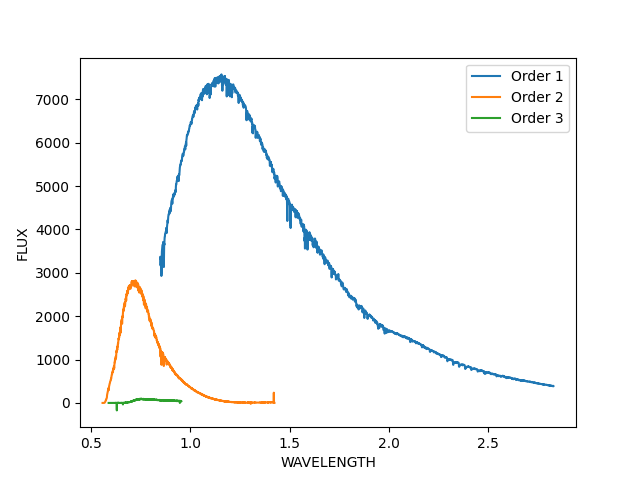

Text(0, 0.5, 'FLUX')

In [20]:
x_key, y_key = 'WAVELENGTH', 'FLUX'
plt.figure()
for spec in result.spec[:3]:
    sp_ord = spec.spectral_order
    plt.plot(spec.spec_table[x_key], spec.spec_table[y_key], label=f'Order {sp_ord}')
plt.legend()
plt.xlabel(x_key)
plt.ylabel(y_key)


### Detector model

In [15]:
model_file = os.path.join(parameters['output_dir'], 'out_SossExtractModel.fits')

In [16]:
soss_model = datamodels.open(model_file)
data = datamodels.open(filename)

In [17]:
soss_model.info(max_rows=50)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.3
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─_fits_hash (str): 6faf36344a8d7296495373199e00799428b515ee1950cdab9cf707f4070af771
├─aperture1 (NDArrayType): shape=(1, 256, 2048), dtype=float32
├─aperture2 (NDArrayType): shape=(1, 256, 2048), dtype=float32
├─aperture3 (NDArrayType): shape=(1, 256, 2048), dtype=float32
├─meta (dict)
│ ├─bunit_data (str): DN/s
│ ├─cal_step (dict)
│ │ ├─dark_sub (str): COMPLETE
│ │ ├─dq_init (str): COMPLETE
│ │ ├─flat_field (str): COMPLETE
│ │ ├─gain_scale (str): SKIPPED
│ │ ├─linearity (str): COMPLETE
│ │ ├─ramp_fit (str): COMPLETE
│ │ ├─refpix (str): COMPLETE
│ │ ├─saturation (str): COMPLETE
│ │ └─superbias (str): COMPLETE
│ ├─calibration_software_revision (str): 6882bd0d
│ ├─calibration_software_version (str): 1.3.4.dev96+g6882bd0d.d20220111
│ ├─

<IPython.core.display.Javascript object>


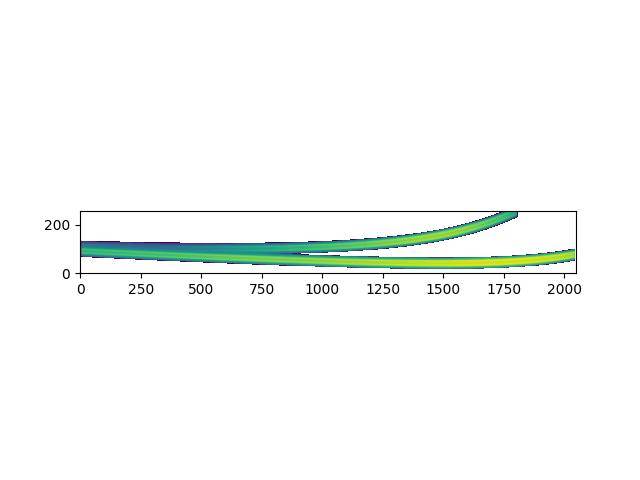

In [22]:
detector_model = soss_model.order1 + soss_model.order2

plt.figure()
plt.imshow(detector_model[0], norm=LogNorm(), origin='lower')

# Looking at the model VS data

In [23]:
diff = (data.data - detector_model)
err_sigma = diff/data.err

<IPython.core.display.Javascript object>


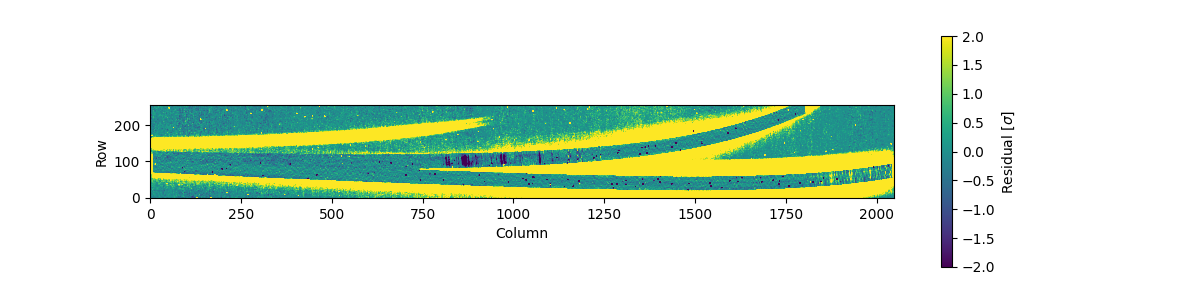

Text(0.5, 0, 'Column')

In [24]:
idx_int = 0  # Index of the integration to plot

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()
im = ax.imshow(err_sigma[idx_int], vmin=-2, vmax=2, origin='lower')
plt.colorbar(im, label=r'Residual $[\sigma]$')
ax.set_ylabel('Row')
ax.set_xlabel('Column')

## Masking all invalid or irrelevant pixels

In [25]:
extracted = (soss_model.aperture1 + soss_model.aperture2) > 0
invalid = bitfield_to_boolean_mask(data.dq)
err_sigma = np.where(extracted & ~invalid, err_sigma, np.nan)

<IPython.core.display.Javascript object>


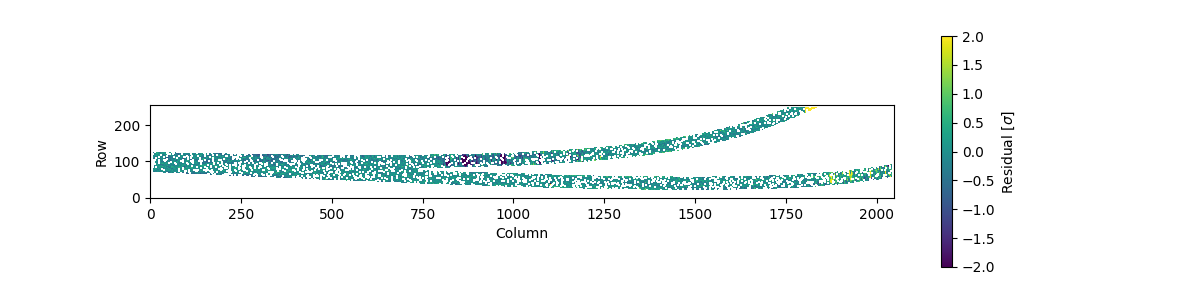

Text(0.5, 0, 'Column')

In [27]:
idx_int = 0  # Index of the integration to plot

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()
im = ax.imshow(err_sigma[idx_int], vmin=-2, vmax=2, origin='lower')
plt.colorbar(im, label=r'Residual $[\sigma]$')
ax.set_ylabel('Row')
ax.set_xlabel('Column')